In [1]:
from google.colab import files
uploaded = files.upload()

Saving df1_loan.csv to df1_loan.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 1. Load Dataset
# ------------------------------
df = pd.read_csv("df1_loan.csv")

# Clean extra unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Standardize column names
df.columns = df.columns.str.strip()


In [3]:
# ------------------------------
# 2. Basic Overview
# ------------------------------
print("Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())

if "Loan_Status" in df.columns:
    print("\nUnique values in outcome variable (Loan_Status):", df["Loan_Status"].unique())
else:
    print("\nColumn 'Loan_Status' not found in dataframe.")

# Convert Loan_Status to numeric for analysis (only if present)
if "Loan_Status" in df.columns:
    df["Loan_Status"] = df["Loan_Status"].map({"Y": 1, "N": 0})

Shape: (500, 14)
Missing Values:
 Loan_ID               0
Gender                9
Married               3
Dependents           12
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           18
Loan_Amount_Term     14
Credit_History       41
Property_Area         0
Loan_Status           0
Total_Income          0
dtype: int64

Unique values in outcome variable (Loan_Status): ['Y' 'N']


In [4]:
# ------------------------------
# 3. Define sensitive features
# ------------------------------
sensitive_features = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]
outcome_var = "Loan_Status"

# Keep only sensitive features that exist in the dataframe
sensitive_features = [f for f in sensitive_features if f in df.columns]


--- Sample Bias: Group Representation ---

Gender distribution (%):
Gender
Male      81.47
Female    18.53
Name: proportion, dtype: float64


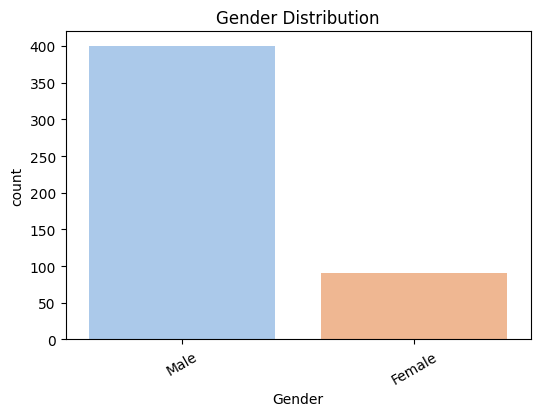


Married distribution (%):
Married
Yes    64.79
No     35.21
Name: proportion, dtype: float64


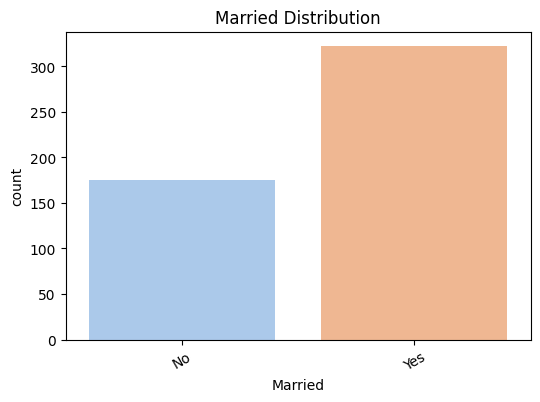


Education distribution (%):
Education
Graduate        78.6
Not Graduate    21.4
Name: proportion, dtype: float64


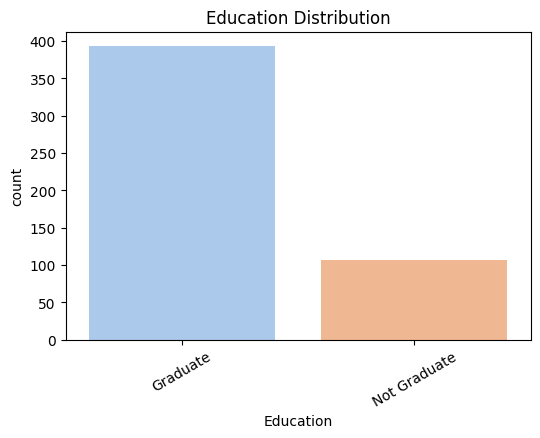


Self_Employed distribution (%):
Self_Employed
No     86.05
Yes    13.95
Name: proportion, dtype: float64


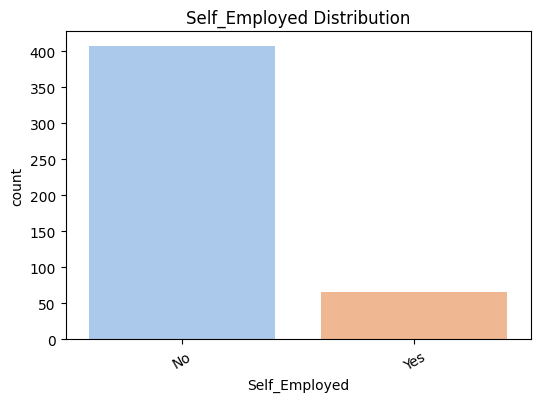


Property_Area distribution (%):
Property_Area
Semiurban    37.6
Urban        34.2
Rural        28.2
Name: proportion, dtype: float64


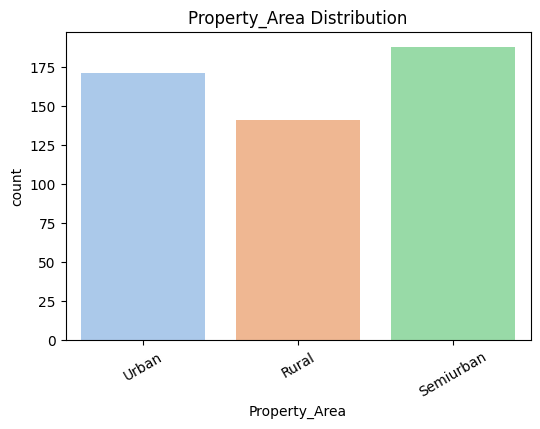

In [5]:
# ------------------------------
# 4. Sample Bias – Representation of Groups
# ------------------------------
print("\n--- Sample Bias: Group Representation ---")
for feat in sensitive_features:
    print(f"\n{feat} distribution (%):")
    print((df[feat].value_counts(normalize=True) * 100).round(2))

    plt.figure(figsize=(6,4))
    sns.countplot(x=feat, data=df, hue=feat, palette="pastel", legend=False)
    plt.title(f"{feat} Distribution")
    plt.xticks(rotation=30)
    plt.show()


--- Label Bias: Approval Rate by Group ---
   Gender  approval_rate
0  Female       0.659341
1    Male       0.697500


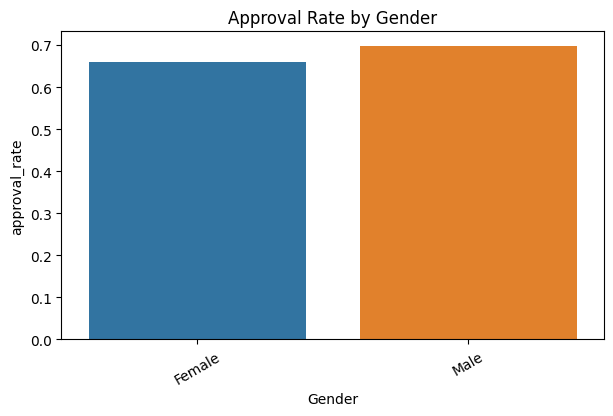

  Married  approval_rate
0      No       0.640000
1     Yes       0.714286


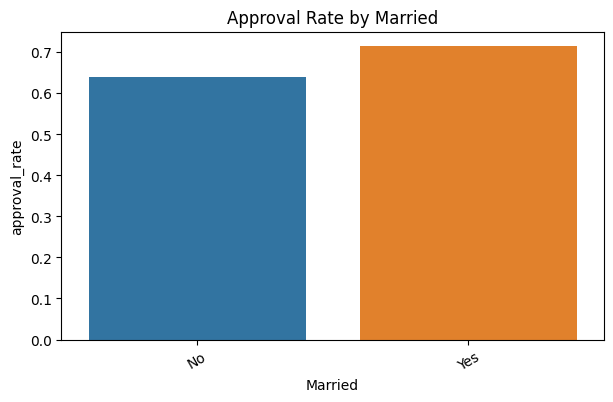

      Education  approval_rate
0      Graduate       0.712468
1  Not Graduate       0.607477


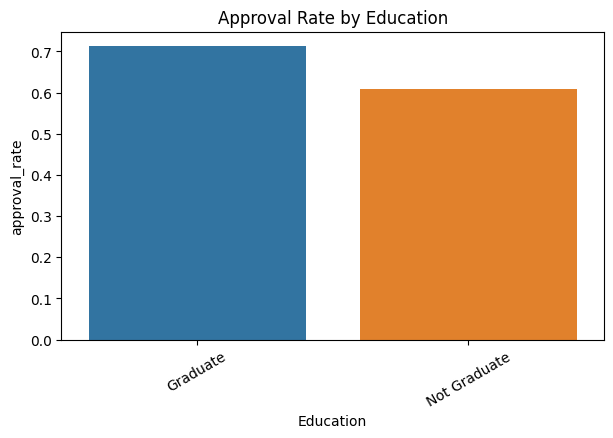

  Self_Employed  approval_rate
0            No       0.690418
1           Yes       0.681818


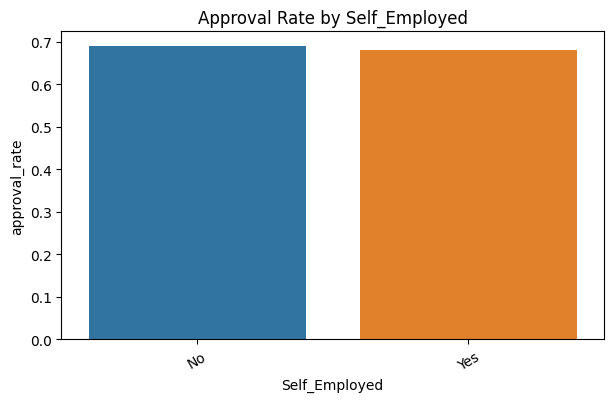

  Property_Area  approval_rate
0         Rural       0.602837
1     Semiurban       0.792553
2         Urban       0.649123


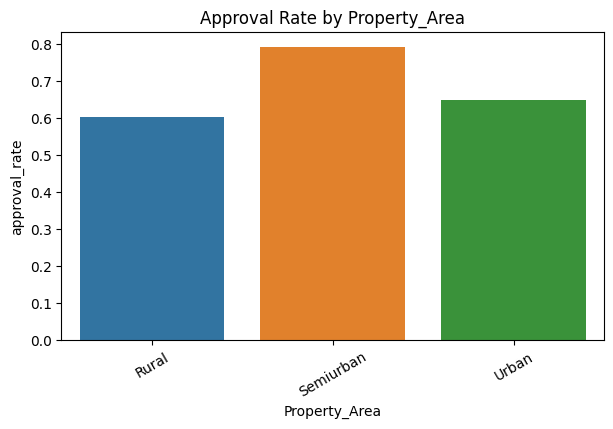

In [6]:
# ------------------------------
# 5. Label Bias – Approval Rate by Group
# ------------------------------
print("\n--- Label Bias: Approval Rate by Group ---")

for feat in sensitive_features:
    grp = df.groupby(feat)[outcome_var].mean().reset_index(name="approval_rate")
    print(grp)

    plt.figure(figsize=(7,4))
    sns.barplot(x=feat, y='approval_rate', data=grp, hue=feat, legend=False)
    plt.title(f"Approval Rate by {feat}")
    plt.xticks(rotation=30)
    plt.show()

In [7]:
# ------------------------------
# 6. Measurement Bias – Missingness by Group
# ------------------------------
print("\n--- Measurement Bias: Missing Data by Group ---")

cols_with_missing = [c for c in df.columns if df[c].isnull().any()]

for feat in sensitive_features:
    print(f"\nMissing value rate by {feat}:")
    if cols_with_missing:
        print(df.groupby(feat)[cols_with_missing].apply(lambda x: x.isnull().mean()))
    else:
        print("No missing values in dataframe.")



--- Measurement Bias: Missing Data by Group ---

Missing value rate by Gender:
        Gender   Married  Dependents  Self_Employed  LoanAmount  \
Gender                                                            
Female     0.0  0.010989    0.032967       0.065934    0.032967   
Male       0.0  0.005000    0.022500       0.052500    0.037500   

        Loan_Amount_Term  Credit_History  
Gender                                    
Female          0.032967        0.087912  
Male            0.027500        0.080000  

Missing value rate by Married:
          Gender  Married  Dependents  Self_Employed  LoanAmount  \
Married                                                            
No       0.00000      0.0    0.017143       0.057143    0.034286   
Yes      0.02795      0.0    0.018634       0.052795    0.034161   

         Loan_Amount_Term  Credit_History  
Married                                    
No               0.028571        0.062857  
Yes              0.027950        0.093168 

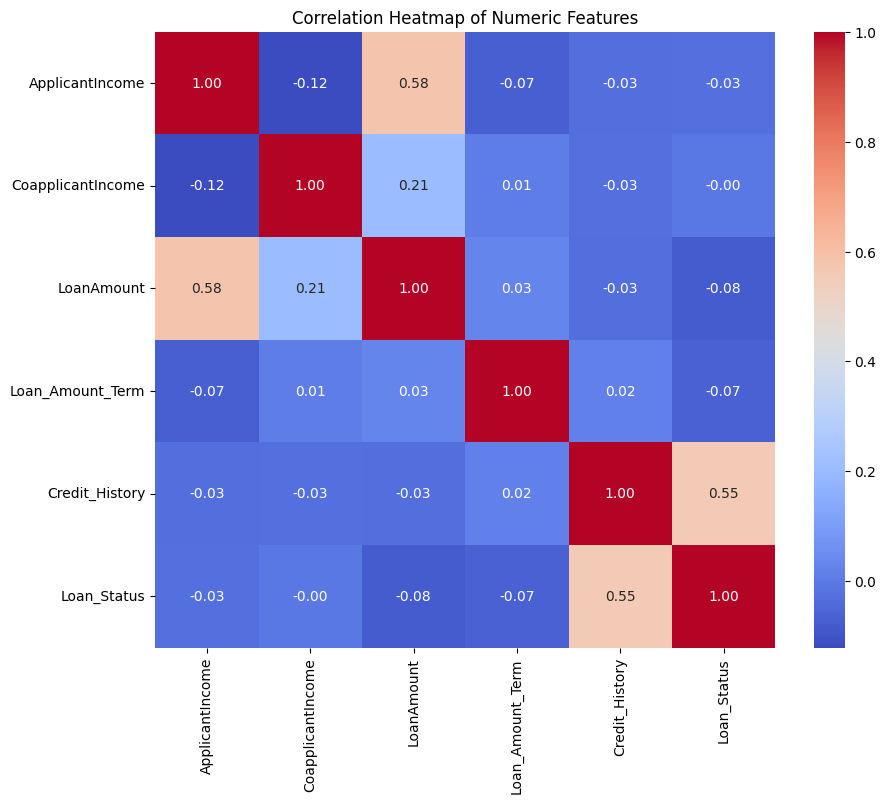

In [8]:

# ------------------------------
# 7. Correlation Heatmap (Numeric Features)
# ------------------------------
num_df = df.select_dtypes(include=[np.number])
if not num_df.empty:
    plt.figure(figsize=(10,8))
    sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()
else:
    print("\nNo numeric columns to compute correlation heatmap.")


In [9]:
# ------------------------------
# 8. Summary
# ------------------------------
print("\n--- Summary of Findings ---")
for feat in sensitive_features:
    if feat in df.columns and outcome_var in df.columns:
        rates = df.groupby(feat)[outcome_var].mean()
        print(f"{feat}: approval rate range {rates.min():.2f}–{rates.max():.2f}")
        counts = df[feat].value_counts(normalize=True)
        under = counts[counts < 0.05]
        if len(under) > 0:
            print("Underrepresented groups (<5%):")
            print(under.round(3))
        print()
    elif feat in df.columns:
        print(f"{feat}: (outcome variable '{outcome_var}' not available for approval rate calculation)\n")

print("Bias detection complete.")



--- Summary of Findings ---
Gender: approval rate range 0.66–0.70

Married: approval rate range 0.64–0.71

Education: approval rate range 0.61–0.71

Self_Employed: approval rate range 0.68–0.69

Property_Area: approval rate range 0.60–0.79

Bias detection complete.
